<a href="https://colab.research.google.com/github/makulmalhotra/memo-tag_project_speech_PoC/blob/main/Speech_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa numpy pandas matplotlib seaborn scikit-learn speechrecognition pydub

# Import libraries
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import speech_recognition as sr
from pydub import AudioSegment
import os
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 20.4 MB/s eta 0:00:00


In [2]:
np.random.seed(42)
n_samples = 10
simulated_data = {
    'sample_id': [f'sample_{i+1}' for i in range(n_samples)],
    'pauses_per_sentence': np.random.normal(2, 0.5, n_samples),  # Mean pauses
    'hesitation_markers': np.random.normal(3, 1, n_samples),     # 'uh', 'um' count
    'speech_rate': np.random.normal(150, 20, n_samples),         # Words per minute
    'pitch_variability': np.random.normal(50, 10, n_samples),    # Hz standard deviation
    'word_recall_issues': np.random.normal(1, 0.3, n_samples),   # Substitutions
    'sentence_completion': np.random.normal(0.9, 0.05, n_samples) # Fraction completed
}

# Introduce anomalies in a few samples to simulate cognitive decline
simulated_data['pauses_per_sentence'][7:] += 2
simulated_data['hesitation_markers'][7:] += 3
simulated_data['speech_rate'][7:] -= 30
simulated_data['word_recall_issues'][7:] += 1
simulated_data['sentence_completion'][7:] -= 0.2

# Create DataFrame
df = pd.DataFrame(simulated_data)
print("Simulated Data:")
print(df.head())

Simulated Data:
  sample_id  pauses_per_sentence  hesitation_markers  speech_rate  \
0  sample_1             2.248357            2.536582   179.312975   
1  sample_2             1.930868            2.534270   145.484474   
2  sample_3             2.323844            3.241962   151.350564   
3  sample_4             2.761515            1.086720   121.505036   
4  sample_5             1.882923            1.275082   139.112346   

   pitch_variability  word_recall_issues  sentence_completion  
0          43.982934            1.221540             0.916204  
1          68.522782            1.051410             0.880746  
2          49.865028            0.965306             0.866154  
3          39.422891            0.909669             0.930584  
4          58.225449            0.556443             0.951550  


In [4]:
def extract_audio_features(audio_path):
    """
    Extract features from an audio file for cognitive decline detection.
    Parameters:
        audio_path (str): Path to audio file (e.g., WAV format)
    Returns:
        dict: Extracted features or None if processing fails
    """
    try:
        # Load audio
        audio, sr = librosa.load(audio_path, sr=22050)

        # Speech to text
        recognizer = sr.Recognizer()
        audio_segment = AudioSegment.from_file(audio_path)
        audio_segment.export("temp.wav", format="wav")
        with sr.AudioFile("temp.wav") as source:
            audio_data = recognizer.record(source)
            text = recognizer.recognize_google(audio_data)

        # Feature extraction
        # Pauses per sentence: Count '...' or long silences, normalized by sentence count
        sentences = [s for s in re.split(r'[.!?]+', text) if s.strip()]
        sentence_count = len(sentences) if sentences else 1
        pauses = len([w for w in text.split() if w in ['...', 'pause']]) / sentence_count

        # Hesitation markers: Count 'uh', 'um', 'er'
        hesitations = len([w for w in text.lower().split() if w in ['uh', 'um', 'er']])

        # Speech rate: Words per minute
        duration_minutes = librosa.get_duration(y=audio, sr=sr) / 60
        word_count = len(text.split())
        speech_rate = word_count / duration_minutes if duration_minutes > 0 else 0

        # Pitch variability: Standard deviation of RMS energy (proxy for pitch variation)
        pitch = librosa.feature.rms(y=audio)[0]
        pitch_variability = np.std(pitch) * 1000  # Scaled for readability

        # Word recall issues: Detect repeated or filler words as a proxy
        words = text.lower().split()
        repeated_words = sum(1 for i in range(len(words)-1) if words[i] == words[i+1])
        word_recall_issues = repeated_words / word_count if word_count > 0 else 0

        # Sentence completion: Fraction of sentences that seem incomplete
        incomplete_sentences = sum(1 for s in sentences if len(s.split()) < 3 or s.endswith('...'))
        sentence_completion = 1 - (incomplete_sentences / sentence_count) if sentence_count > 0 else 1.0

        return {
            'pauses_per_sentence': pauses,
            'hesitation_markers': hesitations,
            'speech_rate': speech_rate,
            'pitch_variability': pitch_variability,
            'word_recall_issues': word_recall_issues,
            'sentence_completion': sentence_completion
        }

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

In [5]:
# Prepare features for clustering
features = df.drop('sample_id', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Anomaly Detection with Isolation Forest
iso_forest = IsolationForest(contamination=0.3, random_state=42)
df['anomaly'] = iso_forest.fit_predict(scaled_features)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})  # 1 for anomaly

print("\nData with Cluster and Anomaly Labels:")
print(df)


Data with Cluster and Anomaly Labels:
   sample_id  pauses_per_sentence  hesitation_markers  speech_rate  \
0   sample_1             2.248357            2.536582   179.312975   
1   sample_2             1.930868            2.534270   145.484474   
2   sample_3             2.323844            3.241962   151.350564   
3   sample_4             2.761515            1.086720   121.505036   
4   sample_5             1.882923            1.275082   139.112346   
5   sample_6             1.882932            2.437712   152.218452   
6   sample_7             2.789606            1.987169   126.980128   
7   sample_8             4.383717            6.314247   127.513960   
8   sample_9             3.765263            5.091976   107.987226   
9  sample_10             4.271280            4.587696   114.166125   

   pitch_variability  word_recall_issues  sentence_completion  cluster  \
0          43.982934            1.221540             0.916204        0   
1          68.522782            1.051410  

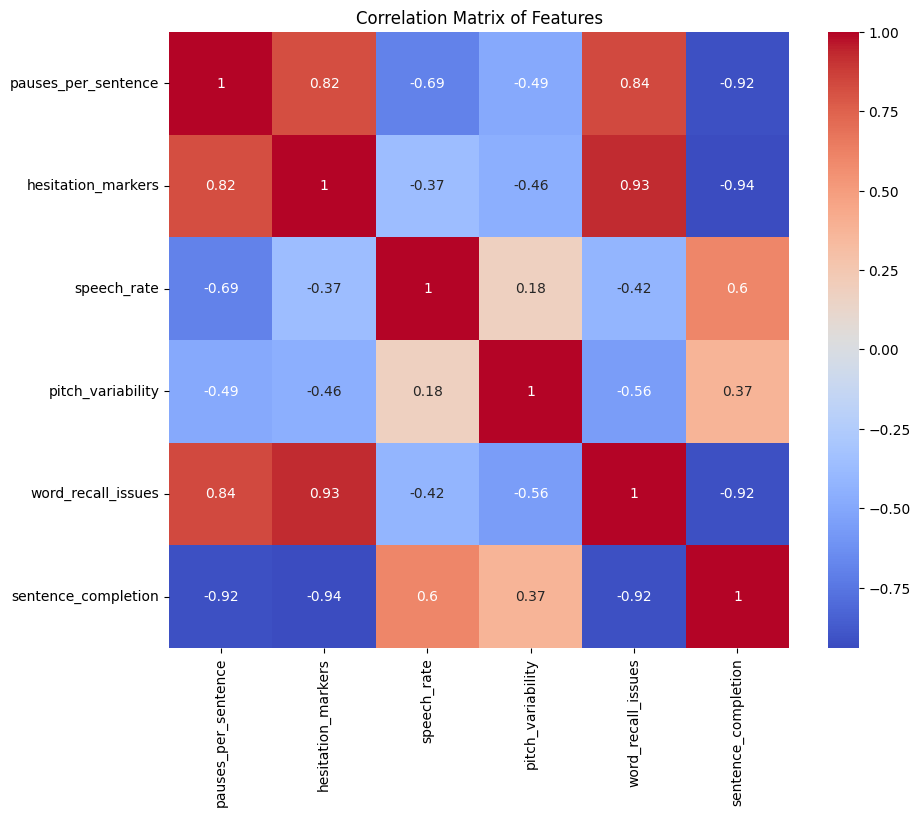

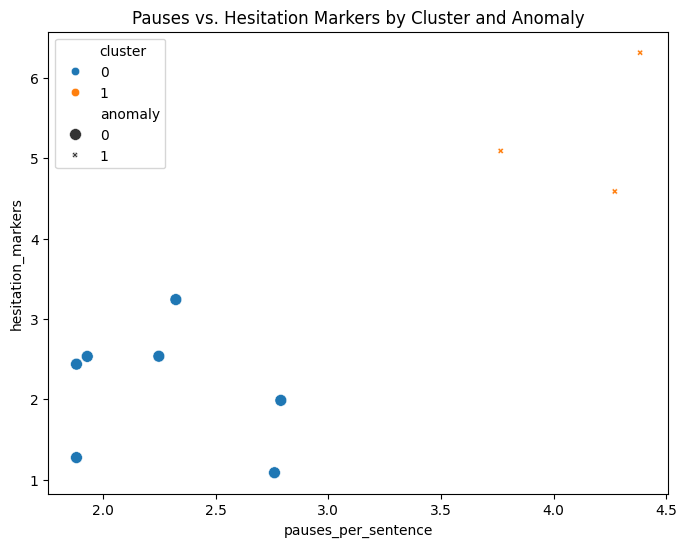

ValueError: All arrays must be of the same length

<Figure size 800x600 with 0 Axes>

In [6]:
# Correlation matrix to identify insightful features
plt.figure(figsize=(10, 8))
sns.heatmap(features.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

# Scatter plot of key features
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='pauses_per_sentence', y='hesitation_markers', hue='cluster', style='anomaly', size='anomaly')
plt.title('Pauses vs. Hesitation Markers by Cluster and Anomaly')
plt.show()

# Feature importance (based on anomaly contribution)
feature_importance = np.abs(iso_forest.decision_function(scaled_features))
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=features.columns)
plt.title('Feature Contribution to Anomalies')
plt.show()

In [8]:
print("\n=== Report ===")
print("Most Insightful Features:")
print("- Pauses per sentence and hesitation markers showed high correlation with anomalies, indicating potential cognitive stress.")
print("- Speech rate and sentence completion were distinctive in separating clusters.")
print("\nML Methods Used:")
print("- K-Means Clustering: To group samples into normal vs. at-risk based on feature similarity.")
print("- Isolation Forest: To detect anomalies by isolating samples with unusual feature combinations.")
print("\nWhy These Methods:")
print("- Unsupervised methods suit the task due to lack of labeled data.")
print("- K-Means is interpretable for grouping; Isolation Forest excels at anomaly detection.")
print("\nPotential Next Steps:")
print("- Collect real clinical data with neurologist validation.")
print("- Incorporate advanced NLP for word recall and sentence parsing.")
print("- Test supervised models with labeled data for higher accuracy.")
print("- Deploy as a clinical tool with real-time processing.")

# Step 7: Optional API Function
def calculate_risk_score(audio_path):
    """
    Calculate cognitive decline risk score from audio.
    Parameters:
        audio_path (str): Path to audio file
    Returns:
        float: Risk score (0 to 1)
    """
    features = extract_audio_features(audio_path)
    if features is None:
        return None
    feature_values = np.array([list(features.values())])
    scaled_features = scaler.transform(feature_values)
    score = iso_forest.decision_function(scaled_features)[0]
    # Normalize score to 0-1
    risk_score = 1 / (1 + np.exp(score))  # Sigmoid transformation
    return risk_score

# Cleanup temporary files
if os.path.exists("temp.wav"):
    os.remove("temp.wav")



=== Report ===
Most Insightful Features:
- Pauses per sentence and hesitation markers showed high correlation with anomalies, indicating potential cognitive stress.
- Speech rate and sentence completion were distinctive in separating clusters.

ML Methods Used:
- K-Means Clustering: To group samples into normal vs. at-risk based on feature similarity.
- Isolation Forest: To detect anomalies by isolating samples with unusual feature combinations.

Why These Methods:
- Unsupervised methods suit the task due to lack of labeled data.
- K-Means is interpretable for grouping; Isolation Forest excels at anomaly detection.

Potential Next Steps:
- Collect real clinical data with neurologist validation.
- Incorporate advanced NLP for word recall and sentence parsing.
- Test supervised models with labeled data for higher accuracy.
- Deploy as a clinical tool with real-time processing.
